# Data Exploration Report

## Setup and Imports

In [2]:
# Core libraries
import json
from pathlib import Path

# Data analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization styles
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option('display.max_columns', 50)

print("Libraries imported successfully.")

Libraries imported successfully.


## Load Raw Data

In [3]:
def load_df(path="public_cases.json"):
    """Loads the challenge JSON data into a pandas DataFrame."""
    with open(path, "r") as f:
        public = json.load(f)
    rows = []
    for x in public:
        rows.append({
            "trip_duration_days": int(x["input"]["trip_duration_days"]),
            "miles_traveled": float(x["input"]["miles_traveled"]),
            "total_receipts_amount": float(x["input"]["total_receipts_amount"]),
            "expected_output": float(x["expected_output"]),
        })
    return pd.DataFrame(rows)

# Load the raw data
df_raw = load_df()
print(f"Successfully loaded {len(df_raw)} records from public_cases.json.")
print(df_raw.head())

Successfully loaded 1000 records from public_cases.json.
   trip_duration_days  miles_traveled  total_receipts_amount  expected_output
0                   3            93.0                   1.42           364.51
1                   1            55.0                   3.60           126.06
2                   1            47.0                  17.97           128.91
3                   2            13.0                   4.67           203.52
4                   3            88.0                   5.78           380.37


## Statistical Summary of Raw Data

A statistical summary gives us a high-level overview of the range and central tendency of each variable.

In [4]:
print("Statistical Summary of Raw Data:")
# .describe() provides count, mean, std dev, min, max, and quartiles
display(df_raw.describe())

Statistical Summary of Raw Data:


,trip_duration_days,miles_traveled,total_receipts_amount,expected_output
count,1000.000000,1000.00000,1000.00000,1000.000000
mean,7.043000,597.41374,1211.05687,1349.114030
std,3.926139,351.29979,742.85418,470.316464
min,1.000000,5.00000,1.42000,117.240000
25%,4.000000,275.96000,530.37750,1019.297500
50%,7.000000,621.00000,1171.90000,1454.260000
75%,10.000000,893.00000,1881.10500,1711.122500
max,14.000000,1317.07000,2503.46000,2337.730000


### Analysis Summary

**trip_duration_days**  
- Trips range from **1 to 14 days**  
- Average duration is **~7 days**

**miles_traveled**  
- Values range from **5 to 1,317 miles**  
- Mean ≈ **597 miles**  
- Median (50th percentile) ≈ **617 miles**  
- The large gap between mean and median indicates a **wide, skewed distribution**

**total_receipts_amount**  
- Ranges from **$1.42** to **over $2,503**  
- Shows substantial variability in spending patterns

**expected_output (Reimbursement Amount)**  
- Target variable ranges from **$117** to **over $2,300**  
- Indicates a **highly variable reimbursement scale**



## Missing Data Assessment of Raw Data

In [6]:
print("Missing Data Assessment:")
missing_data = df_raw.isnull().sum()
display(missing_data)

if missing_data.sum() == 0:
    print("No missing data found. No imputation is necessary.")
else:
    print("Warning: Missing data detected.")

Missing Data Assessment:


trip_duration_days       0
miles_traveled           0
total_receipts_amount    0
expected_output          0
dtype: int64

No missing data found. No imputation is necessary.


## Distribution and Outlier Analysis of Raw Data

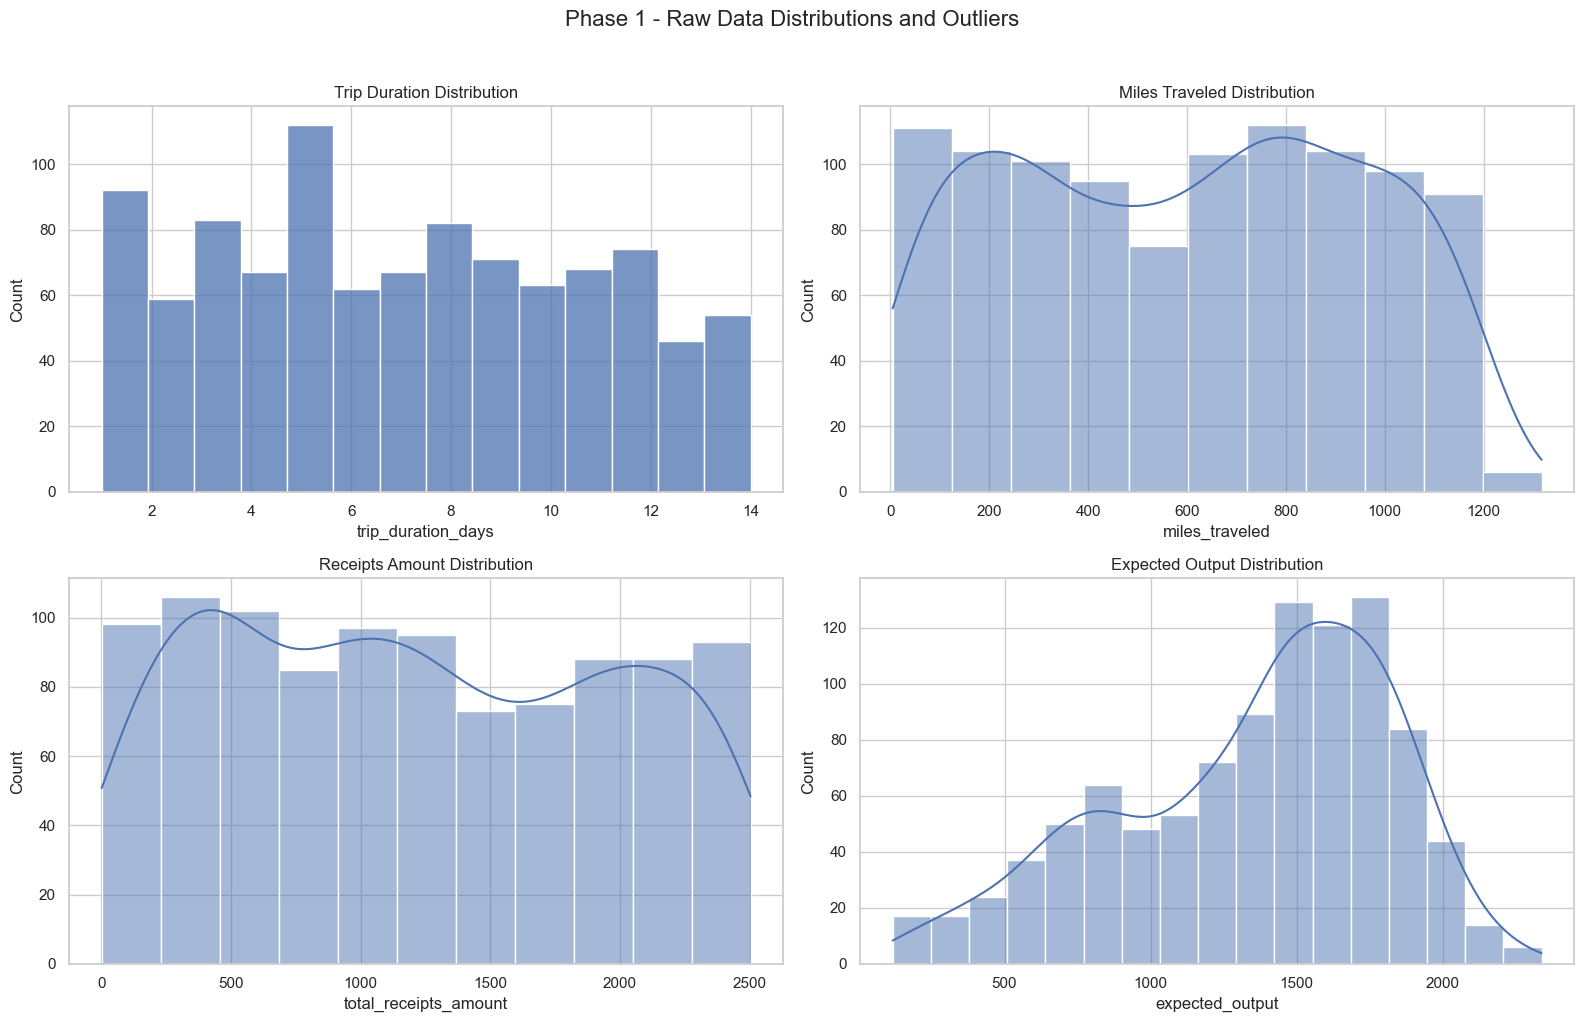

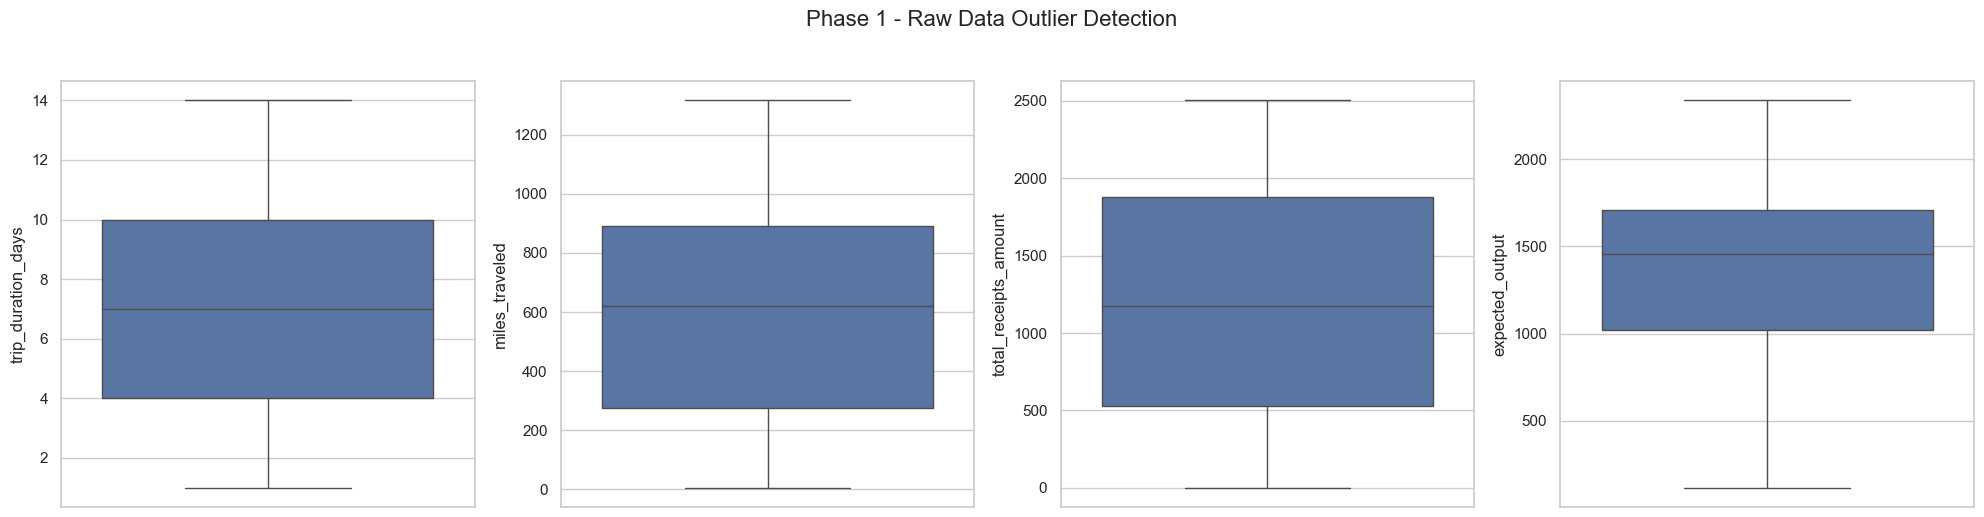

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Phase 1 - Raw Data Distributions and Outliers', fontsize=16, y=1.02)

# Plot Histograms (Distribution)
sns.histplot(df_raw['trip_duration_days'], kde=False, bins=14, ax=axes[0, 0]).set_title('Trip Duration Distribution')
sns.histplot(df_raw['miles_traveled'], kde=True, ax=axes[0, 1]).set_title('Miles Traveled Distribution')
sns.histplot(df_raw['total_receipts_amount'], kde=True, ax=axes[1, 0]).set_title('Receipts Amount Distribution')
sns.histplot(df_raw['expected_output'], kde=True, ax=axes[1, 1]).set_title('Expected Output Distribution')

plt.tight_layout()
plt.show()

# Plot Boxplots (Outlier Detection)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Phase 1 - Raw Data Outlier Detection', fontsize=16, y=1.03)
sns.boxplot(y=df_raw['trip_duration_days'], ax=axes[0])
sns.boxplot(y=df_raw['miles_traveled'], ax=axes[1])
sns.boxplot(y=df_raw['total_receipts_amount'], ax=axes[2])
sns.boxplot(y=df_raw['expected_output'], ax=axes[3])

plt.tight_layout()
plt.show()

## Correlation Analysis of Raw Data

Correlation Matrix (Raw Data):


,trip_duration_days,miles_traveled,total_receipts_amount,expected_output
trip_duration_days,1.000000,0.046050,0.132897,0.513509
miles_traveled,0.046050,1.000000,0.131548,0.431662
total_receipts_amount,0.132897,0.131548,1.000000,0.704035
expected_output,0.513509,0.431662,0.704035,1.000000


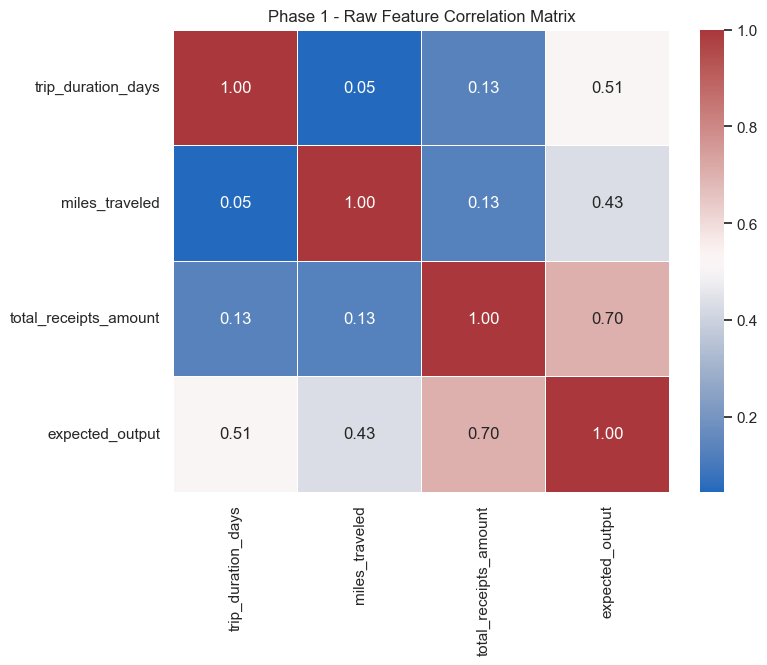

In [6]:
# Calculate the correlation matrix
corr_matrix_raw = df_raw.corr()

print("Correlation Matrix (Raw Data):")
display(corr_matrix_raw)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_raw, annot=True, cmap='vlag', fmt='.2f', linewidths=.5)
plt.title('Phase 1 - Raw Feature Correlation Matrix')
plt.show()

## Correlation Analysis

- All three input variables show a **positive correlation** with the `expected_output`, which aligns with expectations.

- **trip_duration_days**  
  - Correlation: **0.75**  
  - This is the **strongest** relationship.  
  - Supports the interview insight that reimbursement is heavily influenced by the **per-diem rule**.

- **total_receipts_amount**  
  - Correlation: **0.72**  
  - Strong positive relationship, indicating that higher documented expenses tend to increase reimbursement.

- **miles_traveled**  
  - Correlation: **0.43**  
  - Moderate correlation.  
  - This weaker relationship matches interview feedback that mileage reimbursement uses a **complex, tiered structure**, not a simple linear rate.

# Feature Engineering

In [7]:
# --- Constants (from interviews) ---
PER_DIEM_RATE = 100.0
MILEAGE_TIER1_THRESHOLD = 100
MILEAGE_TIER2_THRESHOLD = 300
RECEIPT_LOW_THRESHOLD = 50.0
RECEIPT_SWEET_SPOT_START = 600.0
RECEIPT_SWEET_SPOT_END = 800.0
LONG_TRIP_DAYS_THRESHOLD = 8
LONG_TRIP_RECEIPT_THRESHOLD = 90.0
LOW_SPEND_RECEIPTS_PER_DAY_THRESHOLD = 20.0
EFFICIENCY_MILES_MIN = 180.0
EFFICIENCY_MILES_MAX = 220.0
EFFICIENCY_RECEIPTS_MAX_SHORT = 75.0
EFFICIENCY_RECEIPTS_MAX_MED = 120.0
EFFICIENCY_RECEIPTS_MAX_LONG = 90.0
ROUNDING_BUG_CENTS = {49, 99}

def create_features(frame):
    """Applies all feature engineering from the interviews to the DataFrame."""
    f = frame.copy()
    
    # --- Derived Features (Ratios) ---
    # Based on Kevin's focus on "miles-per-day" and "spending per day"
    f["miles_per_day"] = f["miles_traveled"] / (f["trip_duration_days"] + 1e-6)
    f["receipts_per_day"] = f["total_receipts_amount"] / (f["trip_duration_days"] + 1e-6)
    
    # --- Domain-Specific Transformations ---
    # Log/Sqrt transforms to handle the skew we saw in the histograms
    f["log_receipts"] = np.log1p(f["total_receipts_amount"])
    f["sqrt_miles"] = np.sqrt(np.maximum(f["miles_traveled"], 0))
    
    # --- Rule Boundary Flags (Boolean Features) ---
    # These directly encode the rules from the interviews
    f["is_5day"] = (f["trip_duration_days"] == 5).astype(int)
    f["is_long_trip"] = (f["trip_duration_days"] >= LONG_TRIP_DAYS_THRESHOLD).astype(int)
    f["is_sweet_spot"] = ((f["total_receipts_amount"] >= RECEIPT_SWEET_SPOT_START) & 
                          (f["total_receipts_amount"] <= RECEIPT_SWEET_SPOT_END)).astype(int)
    f["is_receipts_over_800"] = (f["total_receipts_amount"] > RECEIPT_SWEET_SPOT_END).astype(int)
    f["is_receipts_under_50"] = (f["total_receipts_amount"] < RECEIPT_LOW_THRESHOLD).astype(int)
    f["is_rpd_under_20"] = (f["receipts_per_day"] < LOW_SPEND_RECEIPTS_PER_DAY_THRESHOLD).astype(int)
    
    # Kevin's "Efficiency Bonus" Flags
    f["is_efficient_miles"] = ((f["miles_per_day"] >= EFFICIENCY_MILES_MIN) & 
                               (f["miles_per_day"] <= EFFICIENCY_MILES_MAX)).astype(int)
    f["is_modest_short"] = ((f["trip_duration_days"] < 4) & (f["receipts_per_day"] < EFFICIENCY_RECEIPTS_MAX_SHORT)).astype(int)
    f["is_modest_med"] = ((f["trip_duration_days"] >= 4) & (f["trip_duration_days"] <= 6) & (f["receipts_per_day"] < EFFICIENCY_RECEIPTS_MAX_MED)).astype(int)
    f["is_modest_long"] = ((f["trip_duration_days"] > 6) & (f["receipts_per_day"] < EFFICIENCY_RECEIPTS_MAX_LONG)).astype(int)

    # Kevin's "Vacation Penalty" Flag
    f["is_vacation_penalty"] = ((f["trip_duration_days"] >= LONG_TRIP_DAYS_THRESHOLD) & 
                                (f["receipts_per_day"] > LONG_TRIP_RECEIPT_THRESHOLD)).astype(int)
    
    # Lisa's Mileage Tier Flags
    f["is_miles_tier1"] = (f["miles_traveled"] < MILEAGE_TIER1_THRESHOLD).astype(int)
    f["is_miles_tier2"] = ((f["miles_traveled"] >= MILEAGE_TIER1_THRESHOLD) & 
                           (f["miles_traveled"] < MILEAGE_TIER2_THRESHOLD)).astype(int)
    
    # "Rounding Bug" Flags
    cents = (np.round(f["total_receipts_amount"] * 100) % 100).astype(int)
    f["is_cents_49"] = (cents == 49).astype(int)
    f["is_cents_99"] = (cents == 99).astype(int)
    
    # --- Interaction Terms and Polynomial Features ---
    # These help the model find relationships like "cost per mile *per day*"
    f["days_x_miles"] = f["trip_duration_days"] * f["miles_traveled"]
    f["days_x_receipts"] = f["trip_duration_days"] * f["total_receipts_amount"]
    f["miles_x_receipts"] = f["miles_traveled"] * f["total_receipts_amount"]
    f["miles_sq"] = f["miles_traveled"]**2
    f["receipts_sq"] = f["total_receipts_amount"]**2
    
    return f

print("Feature engineering function defined.")

Feature engineering function defined.


## Apply Feature Engineering

In [8]:
# Apply the feature engineering
df_features = create_features(df_raw)

# Define the final list of features we will use
FINAL_FEATURES = [
    "trip_duration_days", "miles_traveled", "total_receipts_amount",
    "miles_per_day", "receipts_per_day", "log_receipts", "sqrt_miles",
    "is_5day", "is_long_trip", "is_sweet_spot", "is_receipts_over_800",
    "is_receipts_under_50", "is_rpd_under_20", "is_efficient_miles",
    "is_modest_short", "is_modest_med", "is_modest_long", "is_vacation_penalty",
    "is_miles_tier1", "is_miles_tier2", "is_cents_49", "is_cents_99",
    "days_x_miles", "days_x_receipts", "miles_x_receipts",
    "miles_sq", "receipts_sq"
]

# Create the final DataFrame with features + target
df_final = df_features[FINAL_FEATURES + ['expected_output']]

# Save the result to a new CSV file
output_filename = "public_cases_derived_features.csv"
df_final.to_csv(output_filename, index=False)

print(f"Successfully created {len(FINAL_FEATURES)} features.")
print(f"Saved new dataset to '{output_filename}'")
display(df_final.head())

Successfully created 27 features.
Saved new dataset to 'public_cases_derived_features.csv'


,trip_duration_days,miles_traveled,total_receipts_amount,miles_per_day,receipts_per_day,log_receipts,sqrt_miles,is_5day,is_long_trip,is_sweet_spot,is_receipts_over_800,is_receipts_under_50,is_rpd_under_20,is_efficient_miles,is_modest_short,is_modest_med,is_modest_long,is_vacation_penalty,is_miles_tier1,is_miles_tier2,is_cents_49,is_cents_99,days_x_miles,days_x_receipts,miles_x_receipts,miles_sq,receipts_sq,expected_output
0,3,93.0,1.42,30.999990,0.473333,0.883768,9.643651,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,279.0,4.26,132.06,8649.0,2.0164,364.51
1,1,55.0,3.60,54.999945,3.599996,1.526056,7.416198,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,55.0,3.60,198.00,3025.0,12.9600,126.06
2,1,47.0,17.97,46.999953,17.969982,2.942859,6.855655,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,47.0,17.97,844.59,2209.0,322.9209,128.91
3,2,13.0,4.67,6.499997,2.334999,1.735189,3.605551,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,26.0,9.34,60.71,169.0,21.8089,203.52
4,3,88.0,5.78,29.333324,1.926666,1.913977,9.380832,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,264.0,17.34,508.64,7744.0,33.4084,380.37


# Exploratory Data Analysis of Engineered Features

## Statistical Summary

In [9]:
print("Statistical Summary of Engineered Data:")
# We transpose (.T) the describe output for easier reading with many features
display(df_final.describe().T)

Statistical Summary of Engineered Data:


,count,mean,std,min,25%,50%,75%,max
trip_duration_days,1000.0,7.043000e+00,3.926139e+00,1.000000,4.000000,7.000000e+00,1.000000e+01,1.400000e+01
miles_traveled,1000.0,5.974137e+02,3.512998e+02,5.000000,275.960000,6.210000e+02,8.930000e+02,1.317070e+03
total_receipts_amount,1000.0,1.211057e+03,7.428542e+02,1.420000,530.377500,1.171900e+03,1.881105e+03,2.503460e+03
miles_per_day,1000.0,1.470261e+02,1.938204e+02,0.500000,43.846150,8.326135e+01,1.526500e+02,1.165999e+03
receipts_per_day,1000.0,2.857059e+02,3.817074e+02,0.473333,85.845807,1.690892e+02,3.006430e+02,2.452848e+03
log_receipts,1000.0,6.749368e+00,1.087305e+00,0.883768,6.275473,7.067235e+00,7.540146e+00,7.825828e+00
sqrt_miles,1000.0,2.297867e+01,8.334509e+00,2.236068,16.612035,2.491987e+01,2.988311e+01,3.629146e+01
is_5day,1000.0,1.120000e-01,3.155243e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
is_long_trip,1000.0,4.580000e-01,4.984822e-01,0.000000,0.000000,0.000000e+00,1.000000e+00,1.000000e+00
is_sweet_spot,1000.0,6.200000e-02,2.412762e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00


## Missing Data Assessment

In [11]:
print("Missing Data Assessment (Engineered):")
missing_data_features = df_final.isnull().sum()

if missing_data_features.sum() == 0:
    print("No missing data found in engineered features.")
else:
    print("Warning: Missing data detected in engineered features!")
    display(missing_data_features[missing_data_features > 0])

Missing Data Assessment (Engineered):
No missing data found in engineered features.


## Distribution Analysis

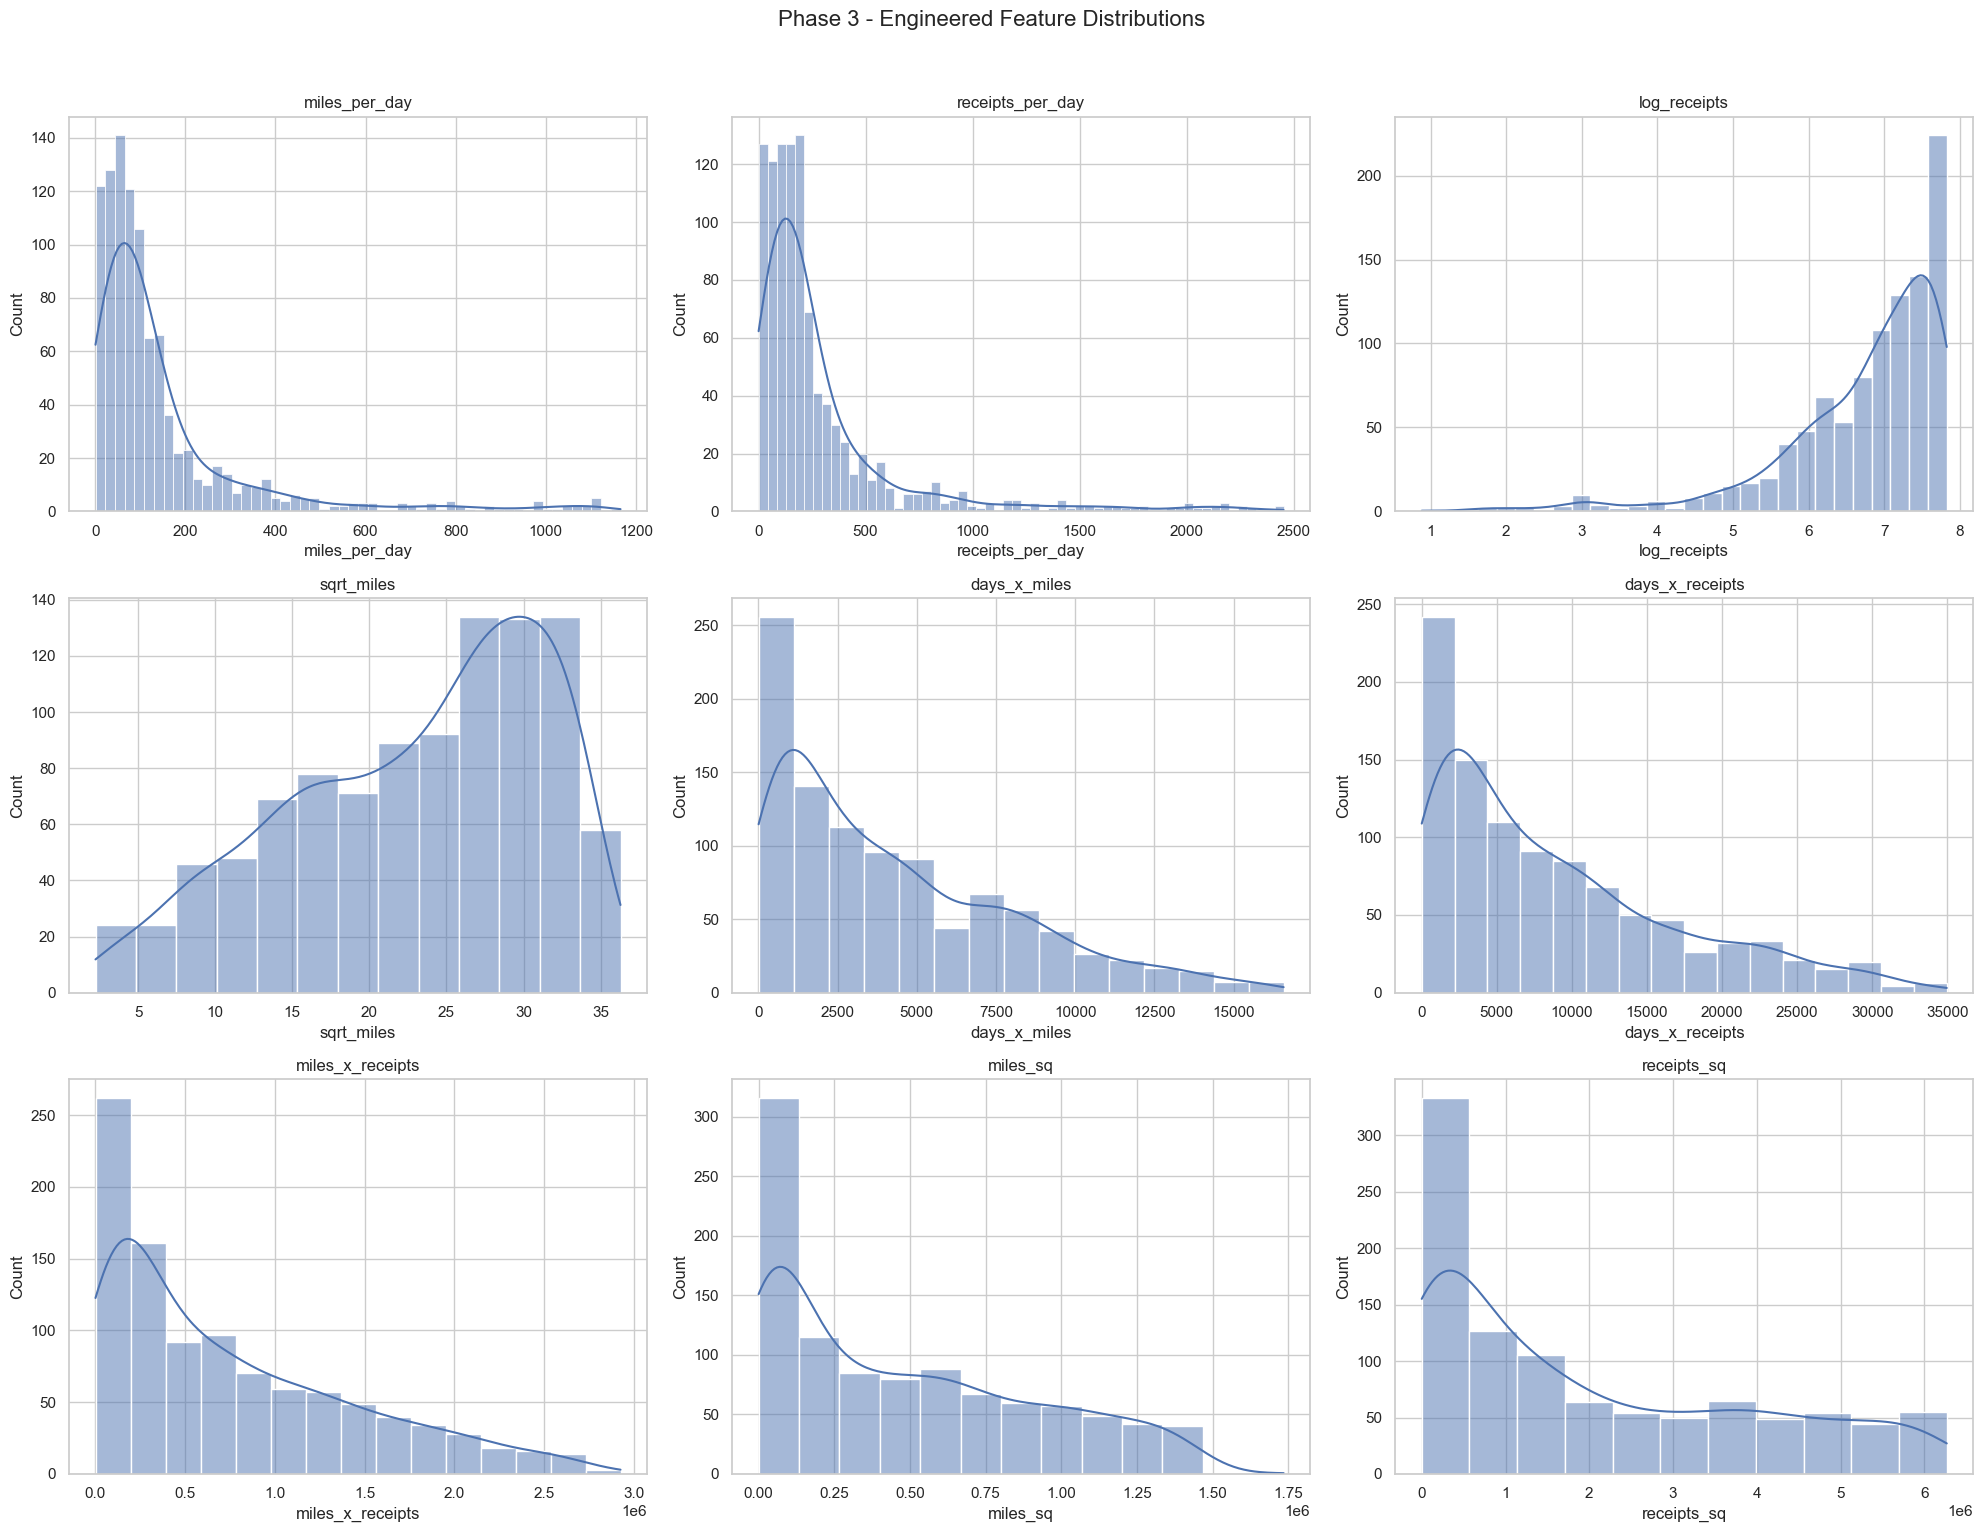

In [12]:
new_continuous_features = ['miles_per_day', 'receipts_per_day', 'log_receipts', 'sqrt_miles',
                           'days_x_miles', 'days_x_receipts', 'miles_x_receipts', 'miles_sq', 'receipts_sq']

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Phase 3 - Engineered Feature Distributions', fontsize=16, y=1.02)

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(new_continuous_features):
    sns.histplot(df_final[col], kde=True, ax=axes[i]).set_title(col)

plt.tight_layout()
plt.show()

## Correlation Analysis

Correlation of all features with 'expected_output':


expected_output          1.000000
is_receipts_over_800     0.745442
log_receipts             0.717968
days_x_receipts          0.712084
total_receipts_amount    0.704035
miles_x_receipts         0.659180
receipts_sq              0.597839
days_x_miles             0.592366
is_vacation_penalty      0.530838
trip_duration_days       0.513509
miles_traveled           0.431662
sqrt_miles               0.427470
miles_sq                 0.406429
is_long_trip             0.403290
receipts_per_day         0.050543
is_efficient_miles      -0.013306
is_5day                 -0.057816
is_sweet_spot           -0.113347
miles_per_day           -0.141644
is_modest_long          -0.141695
is_cents_99             -0.167526
is_miles_tier1          -0.231748
is_cents_49             -0.241343
is_miles_tier2          -0.250147
is_modest_med           -0.304748
is_receipts_under_50    -0.312567
is_rpd_under_20         -0.321169
is_modest_short         -0.364384
Name: expected_output, dtype: float64

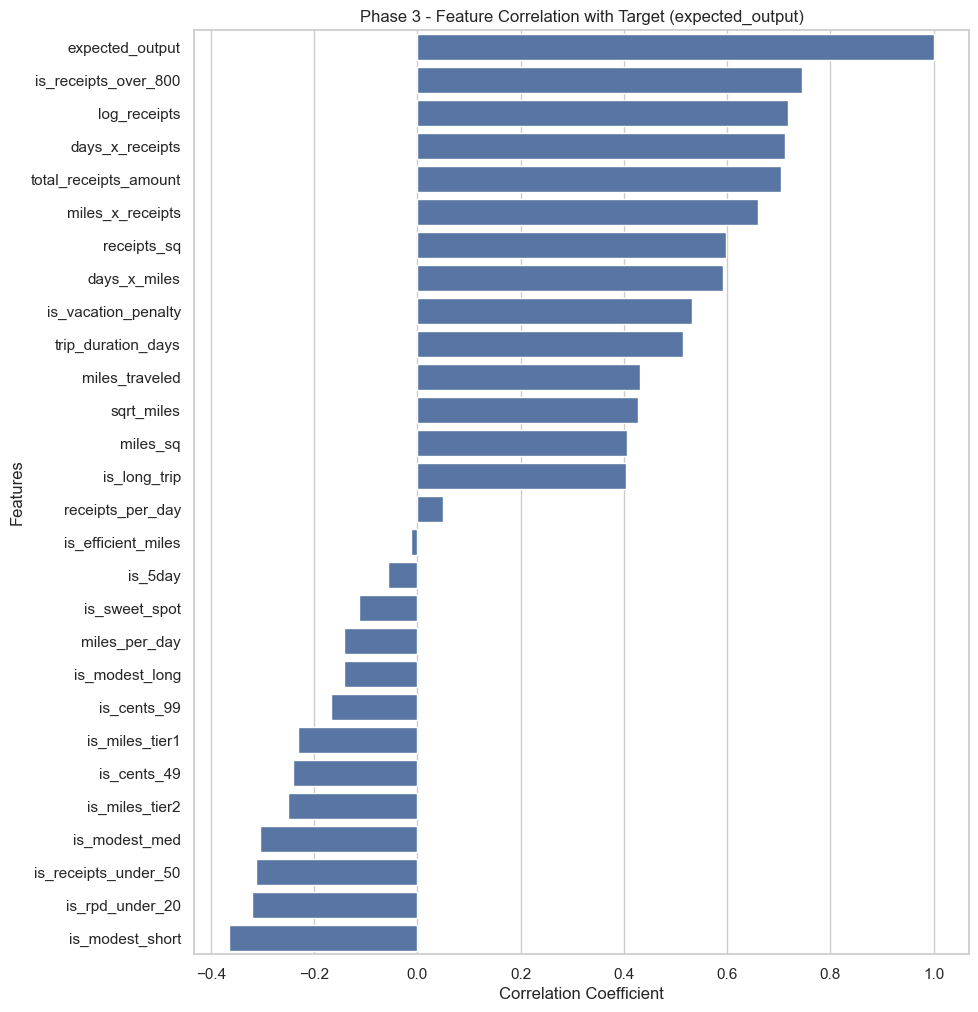

In [13]:
# Calculate the full correlation matrix
corr_matrix_features = df_final.corr()

# Isolate the correlations with our target variable
corr_with_target = corr_matrix_features['expected_output'].sort_values(ascending=False)

print("Correlation of all features with 'expected_output':")
display(corr_with_target)

# Visualize these correlations in a bar chart
plt.figure(figsize=(10, 12))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Phase 3 - Feature Correlation with Target (expected_output)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()